In [1]:
using Revise

using CairoMakie
using Distributions
using LinearAlgebra
using Random

using QuantumCollocation
using NamedTrajectories

pathof(QuantumCollocation)

"/home/andy/Documents/Research/sampling-based-robustness/QuantumCollocation.jl/src/QuantumCollocation.jl"

# Develop

In [ ]:
# # Initial data
# R = 1e-3
# R_a, R_da, R_dda = fill(R, 3)
# Q = 1e2

# a_bounds = fill(1.0, length(H_drives))
# dda_bounds = fill(1.0, length(H_drives))
# drive_derivative_σ = 0.1
# free_time = true
# bound_unitary = false

# init_trajectory = nothing
# a_guess = nothing
# geodesic = true

# integrator = :pade
# pade_order = 4
# autodiff = pade_order != 4

# timesteps_all_equal = true
# leakage_suppression = false
# control_norm_constraint = false

# # QuantumControlProblem data
# blas_multithreading = false
# max_iter = 100
# linear_solver = "mumps"
# verbose = true
# ipopt_options = Options()
# jacobian_structure = true
# hessian_approximation = true
# ;

Goals:

- [x] Construct a system from a bunch of inital samples.
- [x] Construct a problem from a bunch of systems.
- [x] Refactor the problem templates code so the trajectory initialization in unitary smooth pulse is not copy and pasted so much.
- [x] Build a named trajectory with suffixes associated to each system.

In [ ]:
# test = [:a, :b]
# val = [1, 2]
# (; (test .=> val)...)

# # Has to be tuples in this case
# test = (:a, :b)
# val = (1, 2)
# NamedTuple{test}(val)

# (1.0, 1.0) |> typeof <: Tuple{Float64} #, Float64}
# 

In [ ]:
# VectorBound = Union{AbstractVector{R}, Tuple{AbstractVector{R}, AbstractVector{R}}} where R <: Real
# ScalarBound = Union{R, Tuple{R, R}} where R <: Real

In [ ]:
# function initial_control(
#     n_drives::Int,
#     a_bounds::VectorBound,
#     drive_derivative_σ::Float64
# )
#     if a_bounds isa AbstractVector
#         a_dists = [Uniform(-a_bounds[i], a_bounds[i]) for i = 1:n_drives]
#     elseif a_bounds isa Tuple
#         a_dists = [Uniform(aᵢ_lb, aᵢ_ub) for (aᵢ_lb, aᵢ_ub) ∈ zip(a_bounds...)]
#     else
#         error("a_bounds must be a Vector or Tuple")
#     end

#     a = hcat([
#         zeros(n_drives),
#         vcat([rand(a_dists[i], 1, T - 2) for i = 1:n_drives]...),
#         zeros(n_drives)
#     ]...)

#     da = randn(n_drives, T) * drive_derivative_σ
#     dda = randn(n_drives, T) * drive_derivative_σ
#     return a, da, dda
# end

# function initial_control(
#     a_guess::AbstractMatrix,
# )
#     a = a_guess
#     da = derivative(a, Δt)
#     dda = derivative(da, Δt)

#     # to avoid constraint violation error at initial iteration
#     da[:, end] = da[:, end-1] + Δt[end-1] * dda[:, end-1]

#     return a, da, dda
# end

In [ ]:
# function initial_unitary(
#     Ũ⃗_init::AbstractVector{<:Number},
#     Ũ⃗_goal::AbstractVector{<:Number},
#     T::Int;
#     geodesic=true
# )
#     U_init = iso_vec_to_operator(Ũ⃗_init)
#     U_goal = iso_vec_to_operator(Ũ⃗_goal)
#     if geodesic
#         Ũ⃗ = unitary_geodesic(U_goal, T)
#     else
#         Ũ⃗ = unitary_linear_interpolation(U_init, U_goal, T)
#     end
#     return Ũ⃗
# end

In [ ]:
# function initial_trajectory(
#     Ũ⃗_init::AbstractVector{<:Number},
#     Ũ⃗_goal::AbstractVector{<:Number},
#     T::Int,
#     Δt::Real,
#     n_drives::Int,
#     a_bounds::VectorBound,
#     dda_bounds::VectorBound;
#     geodesic=true,
#     bound_unitary=false,
#     free_time=false,
#     Δt_bounds::ScalarBound=(0.5 * Δt, 1.5 * Δt),
#     drive_derivative_σ::Float64=0.1,
#     a_guess::Union{AbstractMatrix{<:Float64}, Nothing}=nothing,
#     system=Union{AbstractQuantumSystem, Nothing}=nothing,
#     rollout_integrator::Function=exp,
#     Ũ⃗_keys::AbstractVector{<:Symbol}=[:Ũ⃗],
# )
#     if free_time
#         if Δt isa Float64
#             Δt = fill(Δt, 1, T)
#         end
#     end

#     # Initial state and controls
#     if isnothing(a_guess)
#         Ũ⃗ = initial_unitary(Ũ⃗_init, Ũ⃗_goal, T; geodesic=geodesic)
#         a, da, dda = initial_control(n_drives, a_bounds, dda_bounds, drive_derivative_σ)
#     else
#         @assert !isnothing(system) "system must be provided if a_guess is provided"
#         Ũ⃗ = unitary_rollout(
#             Ũ⃗_init,
#             a_guess,
#             Δt,
#             system;
#             integrator=rollout_integrator
#         )
#         a, da, dda = initial_control(a_guess)
#     end

#     # Constraints
#     Ũ⃗_inits = repeat([Ũ⃗_init], length(Ũ⃗_keys))
#     initial = (;
#         (Ũ⃗_keys .=> Ũ⃗_inits)...,
#         a = zeros(n_drives),
#     )

#     final = (
#         a = zeros(n_drives),
#     )

#     Ũ⃗_goals = repeat([Ũ⃗_goal], length(Ũ⃗_keys))
#     goal = (; (Ũ⃗_keys .=> Ũ⃗_goals)...)

#     # Bounds
#     bounds = (a = a_bounds, dda = dda_bounds,)

#     if bound_unitary
#         Ũ⃗_dim = length(Ũ⃗_init)
#         Ũ⃗_bounds = repeat([(-ones(Ũ⃗_dim), ones(Ũ⃗_dim))], length(Ũ⃗_keys))
#         merge!(bounds, (; (Ũ⃗_keys .=> Ũ⃗_bounds)...))
#     end

#     # Trajectory
#     Ũ⃗_values = repeat([Ũ⃗], length(systems))
#     keys = [Ũ⃗_keys..., :a, :da, :dda]
#     values = [Ũ⃗_values..., a, da, dda]

#     if free_time
#         push!(keys, :Δt)
#         push!(values, Δt)
#         controls = (:dda, :Δt)
#         timestep = :Δt
#         # merge!(bounds, (Δt = Δt_bounds,))
#         bounds = merge(bounds, (Δt = Δt_bounds,))
#     else
#         controls = (:dda,)
#         timestep = Δt
#     end

#     return NamedTrajectory(
#         (; (keys .=> values)...);
#         controls=controls,
#         timestep=timestep,
#         bounds=bounds,
#         initial=initial,
#         final=final,
#         goal=goal
#     )
# end

In [ ]:
# function set_leakage_suppression!(
#     J::Objective,
#     constraints::Vector{<:AbstractConstraint},
#     traj::NamedTrajectory,
#     operator::EmbeddedOperator;
#     R::Real=1e-1,
#     Ũ⃗_symbol::Symbol=:Ũ⃗,
# )
#     # leakage
#     leakage_indices = get_unitary_isomorphism_leakage_indices(operator)
#     J_leakage, slack_con = L1Regularizer(
#         traj[Ũ⃗_symb],
#         traj;
#         R_value=R,
#         indices=leakage_indices
#     )
#     push!(constraints, slack_con)
#     J += J_leakage
# end

In [ ]:
# Random.seed!(1)

# @assert length(systems) ≥  1 "systems must be a non-empty vector of QuantumSystems"

# if !blas_multithreading
#     BLAS.set_num_threads(1)
# end

# if hessian_approximation
#     ipopt_options.hessian_approximation = "limited-memory"
# end

# Ũ⃗_init = operator_to_iso_vec(U_init)
# Ũ⃗_goal = operator_to_iso_vec(U_goal)
# n_drives = length(systems[1].G_drives)

# Ũ⃗_keys = [add_suffix(:Ũ⃗, ℓ) for ℓ ∈ system_labels]

# # Trajectory
# if !isnothing(init_trajectory)
#     traj = init_trajectory
# else
#     traj = initialize_trajectory(
#         operator,
#         T,
#         Δt,
#         n_drives,
#         a_bounds,
#         dda_bounds;
#         free_time=free_time,
#         Δt_bounds=(Δt_min, Δt_max),
#         geodesic=geodesic,
#         bound_unitary=bound_unitary,
#         drive_derivative_σ=drive_derivative_σ,
#         a_guess=a_guess,
#         system=system,
#         rollout_integrator=rollout_integrator,
#         Ũ⃗_keys=Ũ⃗_keys
#     )
# end

# # Objective
# J = NullObjective()
# for (wᵢ, Ũ⃗ᵢ) in zip(system_weights, Ũ⃗_keys)
#     J += UnitaryInfidelityObjective(
#         Ũ⃗ᵢ, traj, Q; 
#         subspace=operator isa EmbeddedOperator ? operator.subspace_indices : nothing
#     )
# end
# J += QuadraticRegularizer(:a, traj, R_a)
# J += QuadraticRegularizer(:da, traj, R_da)
# J += QuadraticRegularizer(:dda, traj, R_dda)

# # Constraints 
# constraints = AbstractConstraint[]

# if leakage_suppression
#     if operator isa EmbeddedOperator
#         for Ũ⃗ᵢ in Ũ⃗_keys
#             set_leakage_suppression!(
#                 J, constraints, traj, operator, U_symb=Ũ⃗ᵢ, R=R_leakage
#             )
#         end
#     else
#         @warn "leakage_suppression is not supported for non-embedded operators, ignoring."
#     end
# end

# if free_time
#     if timesteps_all_equal
#         push!(constraints, TimeStepsAllEqualConstraint(:Δt, traj))
#     end
# end

# if control_norm_constraint
#     @assert !isnothing(control_norm_constraint_components) "control_norm_constraint_components must be provided"
#     @assert !isnothing(control_norm_R) "control_norm_R must be provided"
#     norm_con = ComplexModulusContraint(
#         :a,
#         control_norm_R,
#         traj;
#         name_comps=control_norm_constraint_components,
#     )
#     push!(constraints, norm_con)
# end

# # Integrators
# unitary_integrators = AbstractIntegrator[]
# for (sysᵢ, Ũ⃗ᵢ) in zip(systems, Ũ⃗_keys)
#     if integrator == :pade
#         push!(
#             unitary_integrators,
#             UnitaryPadeIntegrator(sysᵢ, Ũ⃗ᵢ, :a; order=pade_order, autodiff=autodiff)
#         )
#     elseif integrator == :exponential
#         push!(
#             unitary_integrators,
#             UnitaryExponentialIntegrator(sysᵢ, Ũ⃗ᵢ, :a)
#         )
#     else
#         error("integrator must be one of (:pade, :exponential)")
#     end
# end

# integrators = [
#     unitary_integrators...,
#     DerivativeIntegrator(:a, :da, traj),
#     DerivativeIntegrator(:da, :dda, traj),
# ]

# # ipopt_options.recalc_y = "yes"
# # ipopt_options.recalc_y_feas_tol = 1.0

# prob = QuantumControlProblem(
#     direct_sum(systems),
#     traj,
#     J,
#     integrators;
#     constraints=constraints,
#     max_iter=max_iter,
#     linear_solver=linear_solver,
#     verbose=verbose,
#     ipopt_options=ipopt_options,
#     jacobian_structure=jacobian_structure,
#     hessian_approximation=hessian_approximation,
#     eval_hessian=!hessian_approximation,
#     # kwargs...
# )

# Compare

In [2]:
# System
T = 100
Δt = 0.2

system(ζ) = QuantumSystem(ζ * GATES[:Z], [GATES[:X], GATES[:Y]])
operator = GATES[:H]

# system(ζ) = QuantumSystem(0.0 * GATES[:Z], [(1 + ζ) * GATES[:X]]) #, (1 + ζ) * GATES[:Y]])
# operator = GATES[:X]

ζs = range(-.05, .05, length=5)
systems = [system(ζ) for ζ ∈ ζs]
system_labels = string.(1:length(systems))
system_weights = fill(1.0, length(systems))
;

In [3]:
prob = UnitarySamplingProblem(
    systems,
    operator,
    T,
    Δt;
    system_labels=system_labels,
    system_weights=system_weights,
    ipopt_options=Options(print_level=5, recalc_y = "yes", recalc_y_feas_tol = 10.0)
)

solve!(prob, max_iter=100)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:    43522
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    26420

Total number of variables............................:     4656
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      496
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4455
Total number of inequality c

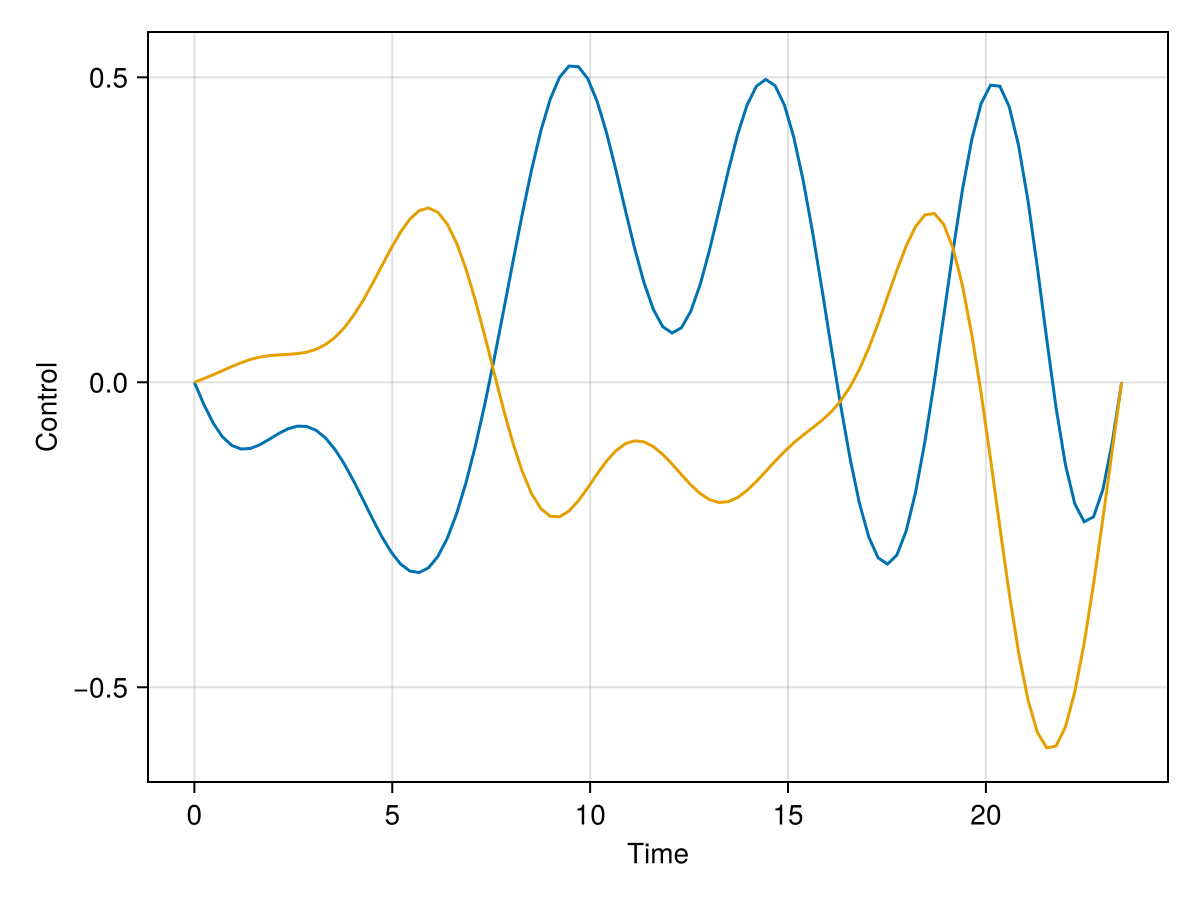

In [4]:
f = Figure()
ax = f[1, 1] = Axis(f, xlabel="Time", ylabel="Control")
times = get_times(prob.trajectory)
for a in eachrow(prob.trajectory[:a])
    lines!(ax, times, a)
end
f

In [18]:
default_prob = UnitarySmoothPulseProblem(
    system(0),
    operator,
    T,
    Δt,
    ipopt_options=Options(print_level=5, recalc_y = "yes", recalc_y_feas_tol = 1.0)
)

solve!(default_prob, max_iter=100)

This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     8866
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     7428

Total number of variables............................:     1488
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      496
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1287
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.4466828e-02 1.82e+00 5.88e-04  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [17]:
# solve!(default_prob, max_iter=200)

This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     8866
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     7428

Total number of variables............................:     1488
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      496
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1287
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.3248535e-03 1.96e-11 3.85e-03  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [6]:
rob_prob = UnitaryRobustnessProblem(
    GATES[:Z],
    UnitarySmoothPulseProblem(system(0),operator,T,Δt,verbose=false),
    final_fidelity=0.9999,
    ipopt_options=Options(recalc_y="yes", recalc_y_feas_tol=1e-2)
)

solve!(rob_prob, max_iter=100)

This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     8866
Number of nonzeros in inequality constraint Jacobian.:        8
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     1488
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      496
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1287
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.6233977e-01 1.91e+00 3.27e-02   0.0 0.00e+00    -  0.00e+00 0.00e+00 

In [19]:
ζs = range(-.1, .1, length=200)
infids = map(ζs) do ζ
    Ũ⃗_end = unitary_rollout(
        prob.trajectory.a, 
        get_timesteps(prob.trajectory), 
        system(ζ)
    )[:, end]
    1 - unitary_fidelity(Ũ⃗_end, operator_to_iso_vec(operator))
end

default_infids = map(ζs) do ζ
    Ũ⃗_end = unitary_rollout(
        default_prob.trajectory.a, 
        get_timesteps(default_prob.trajectory), 
        system(ζ)
    )[:, end]
    1 - unitary_fidelity(Ũ⃗_end, operator_to_iso_vec(operator))
end

rob_infids = map(ζs) do ζ
    Ũ⃗_end = unitary_rollout(
        rob_prob.trajectory.a, 
        get_timesteps(rob_prob.trajectory), 
        system(ζ)
    )[:, end]
    1 - unitary_fidelity(Ũ⃗_end, operator_to_iso_vec(operator))
end
;

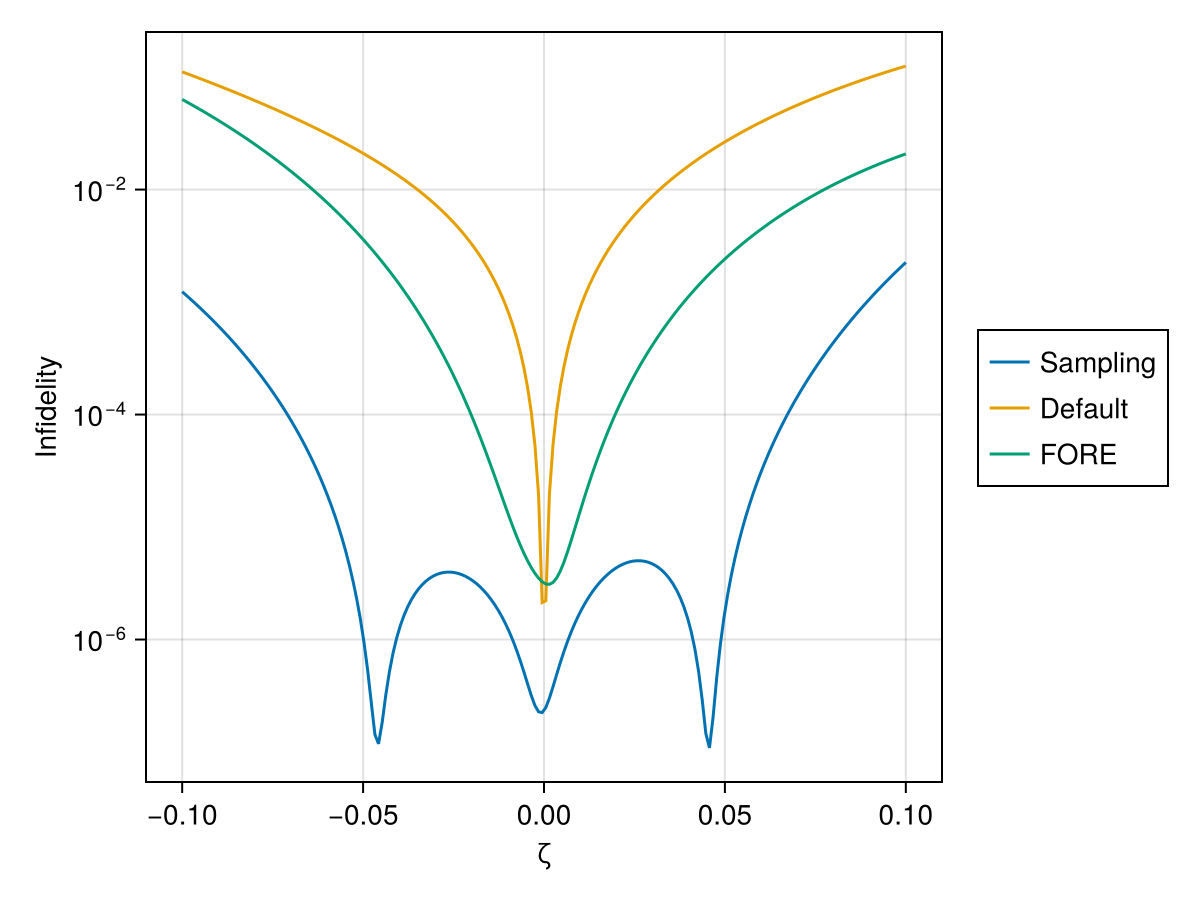

In [20]:
f = Figure()
ax = f[1, 1] = Axis(f, xlabel="ζ", ylabel="Infidelity", yscale=log10)
lines!(ax, ζs, infids, label="Sampling")
lines!(ax, ζs, default_infids, label="Default")
lines!(ax, ζs, rob_infids, label="FORE")
Legend(f[1, 2], ax)
f

# Sample

In [ ]:
prob_ds = UnitarySamplingProblem(
    system,
    Normal(0, 0.1),
    30,
    operator,
    T,
    Δt;
    ipopt_options=Options(print_level=5, recalc_y = "yes", recalc_y_feas_tol = 1e1)
)

In [ ]:
solve!(prob_ds, max_iter=100)

In [ ]:
infids_ds = map(ζs) do ζ
    Ũ⃗_end = unitary_rollout(
        prob_ds.trajectory.a, 
        get_timesteps(prob_ds.trajectory), 
        system(ζ)
    )[:, end]
    1 - unitary_fidelity(Ũ⃗_end, operator_to_iso_vec(operator))
end
;

In [ ]:
f = Figure()
ax = f[1, 1] = Axis(f, xlabel="ζ", ylabel="Infidelity", yscale=log10)
lines!(ax, ζs, infids, label="Sampling")
lines!(ax, ζs, default_infids, label="Default")
lines!(ax, ζs, rob_infids, label="FORE")
lines!(ax, ζs, infids_ds, label="Sampling DS")
Legend(f[1, 2], ax)
f

In [ ]:
f = Figure()
ax = f[1, 1] = Axis(f, xlabel="Time", ylabel="Control")
times = get_times(prob_ds.trajectory)
for a in eachrow(prob_ds.trajectory[:a])
    lines!(ax, times, a)
end
f

In [ ]:
# save("very_robust_trajectory_solution.jld2", prob_ds.trajectory)